In [36]:
import os
from pydub import AudioSegment
from pydub.playback import play
import numpy as np
from scipy.io.wavfile import write
from scipy.signal import convolve

import scipy.io.wavfile as wav
import scipy.signal
from scipy.signal import wiener
import scipy.signal as signal
import matplotlib.pyplot as plt
import soundfile as sf
import sounddevice as sd
from IPython.display import Audio
from scipy.signal import butter, filtfilt, wiener
import numpy as np
from pydub import AudioSegment
from scipy.signal import lfilter

import librosa
import librosa.display
import soundfile as sf

from scipy.signal import stft
from scipy.spatial.distance import cosine
import math

In [37]:

# Folder paths
Input_folder = 'Input'
output_folder = 'output'
os.makedirs(output_folder, exist_ok=True)

# Record audio
filename1 = "audio_data1.wav" 


In [38]:
# Audio recording parameters
samplerate = 44100  # Sample rate in Hz
channels = 1        # Mono audio
duration = 5        # Duration in seconds

def record_audio(filename):
    print("Recording started... Speak now!")
    
    # Record audio in mono
    audio_data = sd.rec(int(samplerate * duration), samplerate=samplerate, channels=channels, dtype='float32')
    sd.wait()  # Wait for the recording to complete
    
    print("Recording finished! Playing the audio...")

    # Save as WAV file in mono format
    sf.write(filename, audio_data, samplerate)

    # Return the recorded audio for playback
    return audio_data


In [39]:
Input_file_path  = os.path.join(Input_folder, filename1)
audio_data1 = record_audio(Input_file_path)

# Play the recorded audio in Jupyter Notebook
Audio(audio_data1.T, rate=samplerate)


Recording started... Speak now!
Recording finished! Playing the audio...


In [40]:
def plot_waveforms(method,input_path, high_path, low_path):
    y_input, sr = librosa.load(input_path, sr=None)
    y_compressed, _ = librosa.load(high_path, sr=None)
    y_output, _ = librosa.load(low_path, sr=None)

    plt.figure(figsize=(10, 6))
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(y_input, sr=sr)
    plt.title(f'Input Audio')

    plt.subplot(3, 1, 2)
    librosa.display.waveshow(y_compressed, sr=sr)
    plt.title(f'{method} High Volume Audio')

    plt.subplot(3, 1, 3)
    librosa.display.waveshow(y_output, sr=sr)
    plt.title(f'{method} Low Volume  Audio')
            
    plt.tight_layout()
    plt.show()


In [41]:
def compute_metrics(ref, target):
    # 1. MSE
    mse = np.mean((ref - target)**2)

    # 2. PSNR
    psnr = 10 * np.log10(1.0 / mse) if mse != 0 else float('inf')

    # 3. SNR
    signal_power = np.mean(ref ** 2)
    noise_power = np.mean((ref - target) ** 2)
    snr = 10 * np.log10(signal_power / noise_power) if noise_power != 0 else float('inf')

    # 4. Log Spectral Distance (LSD)
    def log_spectral_distance(x, y, eps=1e-10):
        f, t, Zx = stft(x, nperseg=512)
        _, _, Zy = stft(y, nperseg=512)
        logX = np.log10(np.abs(Zx) + eps)
        logY = np.log10(np.abs(Zy) + eps)
        return np.mean(np.sqrt(np.mean((logX - logY)**2, axis=0)))

    lsd = log_spectral_distance(ref, target)

    # 5. Cosine Similarity (1 - cosine distance)
    cos_sim = 1 - cosine(ref, target)

    return {
        "MSE": mse,
        "PSNR": psnr,
        "SNR": snr,
        "LSD": lsd,
        "Cosine Similarity": cos_sim
    }


In [42]:
def measure_metrics(method, input_path, high_path, low_path):
    y_input, sr = librosa.load(input_path, sr=None)
    y_high, _ = librosa.load(high_path, sr=None)
    y_low, _ = librosa.load(low_path, sr=None)

    # Pad or trim to match length
    min_len = min(len(y_input), len(y_high), len(y_low))
    y_input = y_input[:min_len]
    y_high = y_high[:min_len]
    y_low = y_low[:min_len]

    print(f"\n=== {method.upper()} METRICS ===")
    
    print("\n📈 High Volume Output Metrics:")
    high_metrics = compute_metrics(y_input, y_high)
    for k, v in high_metrics.items():
        print(f"{k}: {v:.4f}")

    print("\n📉 Low Volume Output Metrics:")
    low_metrics = compute_metrics(y_input, y_low)
    for k, v in low_metrics.items():
        print(f"{k}: {v:.4f}")

In [43]:
def fixed_pitch_shift(filepath,  semitones, volume_mode, output_path ):
    # Load audio
    y, sr = librosa.load(filepath, sr=None)
    
    # Pitch shifting
    y_shifted = librosa.effects.pitch_shift(y, sr, n_steps=semitones)

    # Volume control
    if volume_mode == 'high':
        y_shifted *= 5
    elif volume_mode == 'low':
        y_shifted *= 0.5
    elif isinstance(volume_mode, (int, float)):
        y_shifted *= volume_mode
    # Else 'original' does nothing

    # Clip signal to avoid overflow
    y_shifted = np.clip(y_shifted, -1.0, 1.0)

    # Save to file
    sf.write(output_path, y_shifted, sr)

In [44]:
output_file_path = 'existing_output_low.wav'
fixed_pitch_shift(Input_file_path, 5, 'low', output_file_path)
Audio(output_file_path, autoplay=False)

c:\Users\geeth\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


In [45]:
output_file_path1 = 'existing_output_high.wav'
fixed_pitch_shift(Input_file_path, 5, 'high', output_file_path)
Audio(output_file_path1, autoplay=False)

c:\Users\geeth\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


In [46]:
measure_metrics("Existing",Input_file_path, output_file_path1, output_file_path)


=== EXISTING METRICS ===

📈 High Volume Output Metrics:
MSE: 0.0003
PSNR: 35.5816
SNR: -1.9660
LSD: 0.7532
Cosine Similarity: -0.0094

📉 Low Volume Output Metrics:
MSE: 0.0022
PSNR: 26.5938
SNR: -10.9538
LSD: 0.8083
Cosine Similarity: 0.0145


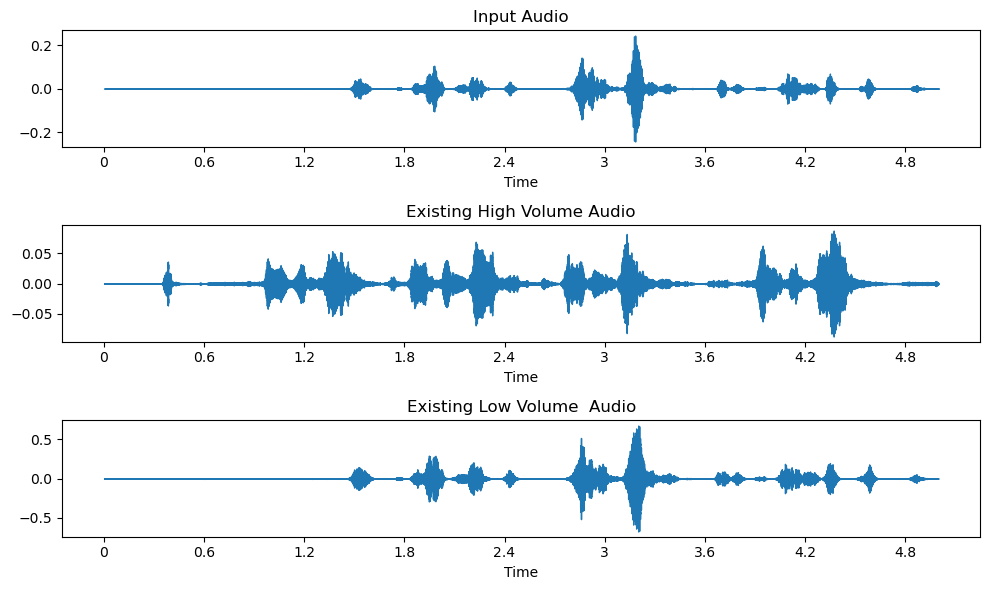

In [47]:
plot_waveforms("Existing",Input_file_path, output_file_path1, output_file_path)

In [48]:
def flexible_pitch_shift(audio_data, sample_rate, low_freq, high_freq):
    nyquist = 0.5 * sample_rate  # Nyquist frequency is half the sample rate
    low = low_freq / nyquist     # Normalize the lower cutoff frequency
    high = high_freq / nyquist   # Normalize the higher cutoff frequency
    b, a = scipy.signal.butter(4, [low, high], btype='band')
    filtered_audio = scipy.signal.filtfilt(b, a, audio_data)
    return filtered_audio

In [49]:
def flexible_pitch_shift_final(compressed_file_path, volume, volume_mode='original'):
    # Load audio
    audio_data, sample_rate = sf.read(compressed_file_path)
    gain_factor= 0.75
    low_freq=200
    high_freq=5000
    # Pitch shifting
    # Volume control
    if volume_mode == 'high':
        volume_control =  volume * 5
    elif volume_mode == 'low':
        volume_control =  volume * 0.005
    else:
        volume_control =  volume

    filtered_audio = flexible_pitch_shift(audio_data, sample_rate, low_freq, high_freq)
    filtered_audio = filtered_audio * gain_factor  
    
    max_value = np.max(np.abs(filtered_audio))
    if max_value > 0:
        recovered_audio = filtered_audio / max_value  # Normalize to -1 to 1 range
    
    return recovered_audio*volume_control,sample_rate

In [50]:
output_file_path="output_low.wav"
out,sample_rate = flexible_pitch_shift_final(Input_file_path, volume=5, volume_mode='low')
sf.write(output_file_path, out, sample_rate, format='WAV')

In [51]:
Audio(output_file_path, autoplay=False)

In [52]:
output_file_path="output_high.wav"
out,sample_rate = flexible_pitch_shift_final(Input_file_path, volume=5, volume_mode='high')
sf.write(output_file_path, out, sample_rate, format='WAV')

In [53]:
Audio(output_file_path, autoplay=False)

In [54]:
output_file_path1="output_high.wav"
out,sample_rate = flexible_pitch_shift_final(Input_file_path, volume=5, volume_mode='custom')
sf.write(output_file_path1, out, sample_rate, format='WAV')

In [55]:
Audio(output_file_path, autoplay=False)

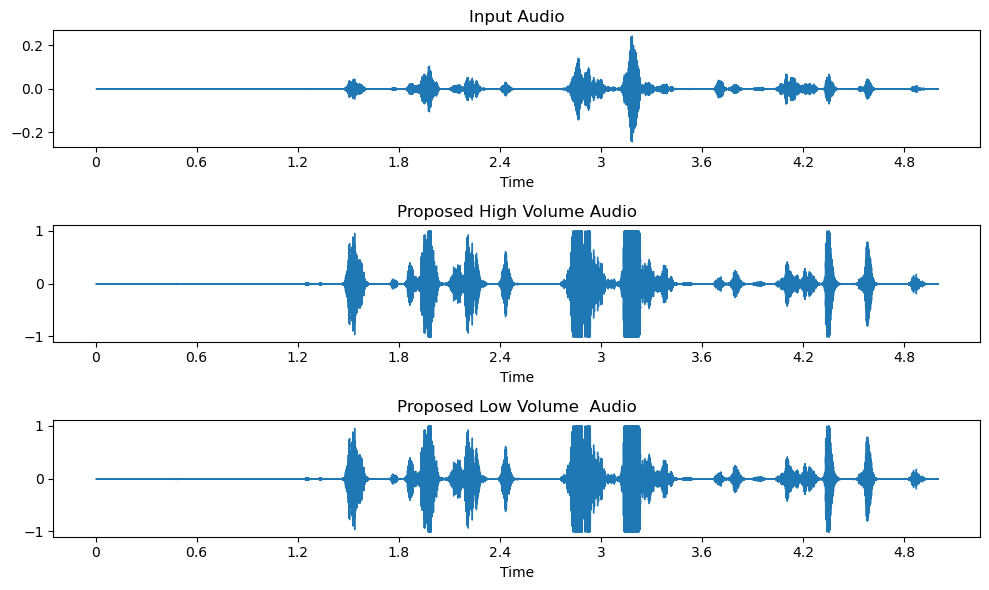

In [56]:
plot_waveforms("Proposed",Input_file_path, output_file_path1, output_file_path)

In [57]:
measure_metrics("Proposed",Input_file_path, output_file_path1, output_file_path)


=== PROPOSED METRICS ===

📈 High Volume Output Metrics:
MSE: 0.0264
PSNR: 15.7812
SNR: -21.7664
LSD: 0.8039
Cosine Similarity: 0.8541

📉 Low Volume Output Metrics:
MSE: 0.0264
PSNR: 15.7812
SNR: -21.7664
LSD: 0.8039
Cosine Similarity: 0.8541
